## 导入包

In [1]:
from __future__ import print_function

import time
from PIL import Image
import numpy as np

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
import tensorflow as tf
#from tensorflow.keras import backend

Using TensorFlow backend.


## 参数

In [2]:
# 图片统一大小
height = 512
width = 512
# 权重
content_weight = 0.025
style_weight = 5.0
total_variation_weight = 1.0
# 使用层号
feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']
# 训练次数
iterations = 5

## 路径

In [3]:
# 内容图片路径
#content_image_path = '/home/liuzixuan/实训/02-用Python快速实现图片的风格迁移/img/hugo.jpg'
# 风格图片路径
#style_image_path = '/home/liuzixuan/实训/02-用Python快速实现图片的风格迁移/img/wave.jpg'
img_path = '/home/liuzixuan/实训/02-用Python快速实现图片的风格迁移/img/'

## 显示图片

In [4]:
def show_image(img_path):
    img = Image.open(img_path)
    img = img.resize((width,height))
    return img

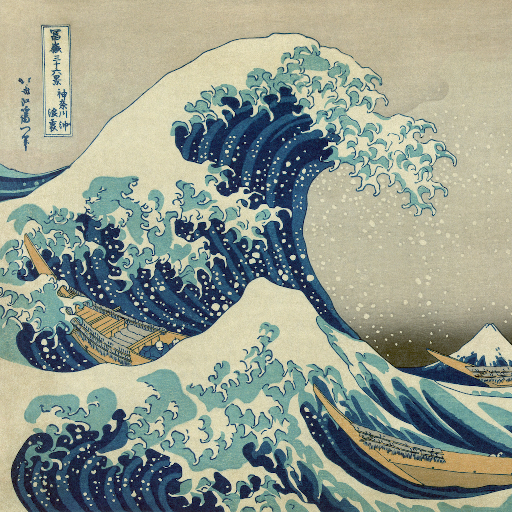

In [5]:
style_image_path = '/home/liuzixuan/实训/02-用Python快速实现图片的风格迁移/img/wave.jpg'
style_image = show_image(style_image_path)
style_image

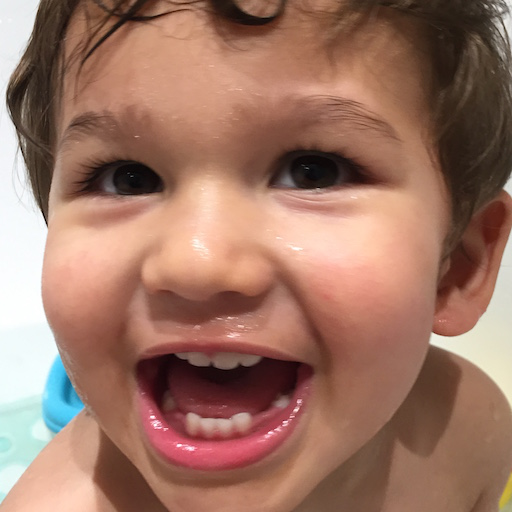

In [6]:
content_image_path = '/home/liuzixuan/实训/02-用Python快速实现图片的风格迁移/img/hugo.jpg'
content_image = show_image(content_image_path)
content_image

## 图片转数组并中心化

In [5]:
def img_array(img):
    img_array = np.asarray(img,dtype='float32')
    img_array = np.expand_dims(img_array,axis=0)
    img_array[:,:,:,0] -= 103.939
    img_array[:,:,:,1] -= 116.779
    img_array[:,:,:,2] -= 123.68
    img_array = img_array[:,:,:,::-1]
    return img_array

In [8]:
style_array = img_array(style_image)
print(style_array.shape)
content_array = img_array(content_image)
print(content_array.shape)

(1, 512, 512, 3)
(1, 512, 512, 3)


## 内容损失函数

In [6]:
def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

## 风格损失函数

In [7]:
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    return backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

## 损失函数

In [8]:
def total_variation_loss(x):
    a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))

def loss_function(content_image_features,layer_features,combination_features,combination_image,feature_layers):
    #loss = backend.variable(0.)
    loss = content_weight * content_loss(content_image_features,combination_features)
    
    for layer_name in feature_layers:
        layer_features = layers[layer_name]
        style_features = layer_features[1, :, :, :]
        com_features = layer_features[2, :, :, :]
        sl = style_loss(style_features, com_features)
        loss += (style_weight / len(feature_layers)) * sl
    
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

## 求值程序

In [9]:
def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

## 还原

In [10]:
def reduction(combination_array):
    combination_array = combination_array.reshape((height,width,3))
    combination_array = combination_array[:,:,::-1]
    combination_array[:,:,0] += 103.939
    combination_array[:,:,1] += 116.779
    combination_array[:,:,2] += 123.68
    combination_array = np.clip(combination_array,0,255).astype('uint8')
    combination_image = Image.fromarray(combination_array)
    return combination_image

## 构造图Graph

## 训练

In [13]:
for i in range(1,7):
    content_image_path = img_path + 'img0' + str(i) + '.jpg'
    content_image = show_image(content_image_path)
    content_array = img_array(content_image)
    for j in range(1,3):
        print('combination_image %d %d' % (i,j))
        style_image_path = img_path + 'style0' + str(j) + '.jpg'
        style_image = show_image(style_image_path)
        style_array = img_array(style_image)
        # 定义占位符
        content_image = backend.variable(content_array)
        style_image = backend.variable(style_array)
        combination_image = backend.placeholder((1,height,width,3))
        # 输入值
        input_tensor = backend.concatenate([content_image,style_image,combination_image], axis=0)
        #print(input_tensor.shape)#(3,512,512,3)
        # 模型加载
        model = VGG16(input_tensor=input_tensor, weights='imagenet',include_top=False)
        # 层数字典
        layers = dict([(layer.name, layer.output) for layer in model.layers])
        
        #loss = backend.variable(0.)

        # 特征图
        layer_features = layers['block2_conv2']
        content_image_features = layer_features[0, :, :, :]
        combination_features = layer_features[2, :, :, :]
        # 代价
        loss = loss_function(content_image_features,layer_features,combination_features,combination_image,feature_layers)
    
        grads = backend.gradients(loss, combination_image)
        outputs = [loss]
        outputs += grads
        f_outputs = backend.function([combination_image], outputs)
    
        evaluator = Evaluator()
        
        x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

        res_loss = []
        for step in range(iterations):
            #print('Start of iteration', i)
            #start_time = time.time()
            x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),fprime=evaluator.grads, maxfun=20)
            #print('Current loss value:', min_val)
            res_loss.append(min_val)
            #end_time = time.time()
            #print('Iteration %d completed in %ds' % (step, end_time - start_time))
        min_loss = min(res_loss)
        print(min_loss)
        combination_image = reduction(x)
        combination_image

combination_image 1 1


ResourceExhaustedError: OOM when allocating tensor with shape[3,64,512,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: gradients_4/AddN_14/tmp_var_zeros = ZerosLike[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](gradients_4/AddN_14-0-TransposeNHWCToNCHW-LayoutOptimizer)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: add_34/_827 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_901_add_34", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [13]:
# 定义占位符
content_image = backend.variable(content_array)
style_image = backend.variable(style_array)
combination_image = backend.placeholder((1,height,width,3))
# 输入值
input_tensor = backend.concatenate([content_image,style_image,combination_image], axis=0)
#print(input_tensor.shape)#(3,512,512,3)

In [14]:
# 模型加载
model = VGG16(input_tensor=input_tensor, weights='imagenet',include_top=False)
# 层数字典
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

{'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 256, 256, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 128, 128, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(3, 64, 64, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1/Relu:0' shape=(3, 64, 64, 512) dtype=float32>,
 'b

In [15]:
#loss = backend.variable(0.)

# 特征图
layer_features = layers['block2_conv2']
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
# 代价
loss = loss_function(content_image_features,layer_features,combination_features,combination_image,feature_layers)
    
grads = backend.gradients(loss, combination_image)
outputs = [loss]
outputs += grads
f_outputs = backend.function([combination_image], outputs)
    
evaluator = Evaluator()

In [27]:
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

iterations = 5

res_loss = []
for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    res_loss.append(min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))
min_loss = min(res_loss)
print(min_loss)

Start of iteration 0
Current loss value: 80336370000.0
Iteration 0 completed in 28s
Start of iteration 1
Current loss value: 51752997000.0
Iteration 1 completed in 27s
Start of iteration 2
Current loss value: 42767310000.0
Iteration 2 completed in 26s
Start of iteration 3
Current loss value: 39337726000.0
Iteration 3 completed in 28s
Start of iteration 4
Current loss value: 37696602000.0
Iteration 4 completed in 31s
37696602000.0


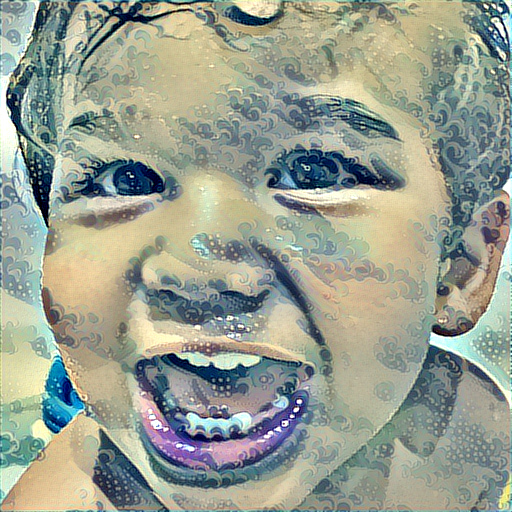

In [28]:
combination_image = reduction(x)
combination_image